# XGBoost


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [3]:
X_train = pd.read_csv("../../data/X_train.csv", index_col=0)
y_train = pd.read_csv("../../data/y_train.csv", index_col=0)
X_test = pd.read_csv("../../data/X_test.csv", index_col=0)
y_test = pd.read_csv("../../data/y_test.csv", index_col=0)

## Hyperparameter tuning

Really focus on tuning this model as I hope that this will be the best performing model for the project. Then see if I can extract the most important features for the model. Try using either RandomizedSearchCV or Bayesian Optimization as these will be much faster than GridSearchCV. 

In [4]:
def hyperparameter_tuning(X_train, X_test, y_train, y_test, function, param_grid, scoring, cv):
    mod_cv = sklearn.model_selection.RandomizedSearchCV(function, n_iter=100, 
                                                        param_distributions=param_grid, scoring=scoring, cv=cv)
    
    mod_cv.fit(X_train, y_train)
    best_param = mod_cv.best_params_
    best_train_score = mod_cv.best_score_
    
    y_pred = mod_cv.predict(X_test)
    
    score_dict = {"Best Hyperparameters": best_param,
                  "Best training score": best_train_score,
                  "Accuracy": sklearn.metrics.accuracy_score(y_test, y_pred), 
                  "F1 score": sklearn.metrics.f1_score(y_test, y_pred),
                  "AUC": sklearn.metrics.roc_auc_score(y_test, y_pred)}
            
    return score_dict, y_pred

In [6]:
boost = xgb.XGBClassifier(verbosity=0)

scores = {}
y_preds = {}

param_grid = {"n_estimators": [35, 45, 50],
              "objective": ["reg:logistic", "binary:logistic"],
              "booster": ["gbtree", "gblinear", "dart"],
              "tree_method": ["exact", "approx", "hist"], 
              "gamma": [10, 12, 15],
              "lambda": [0.3, 0.7],
              "alpha": [0.1, 0.3],
              "max_depth": np.arange(3, 18, 3),
              "eta": [0.1, 0.3, 0.5], 
              "min_child_weight": [1, 10, 50],
              "subsample": [0.5, 0.8, 0.95], 
              "colsample_bytree": np.arange(0.3, 1, 0.1)}

for i in y_train.columns:
    print(f"{i} prediction", "\n")
    
    train = y_train[i]
    test = y_test[i]
    
    scores[i], y_preds[i] = hyperparameter_tuning(X_train, X_test, train, test, function=boost, param_grid=param_grid, scoring="accuracy", cv=5)
    
    print(scores[i], "\n")

Happiness prediction 

{'Best Hyperparameters': {'tree_method': 'approx', 'subsample': 0.95, 'objective': 'binary:logistic', 'n_estimators': 50, 'min_child_weight': 10, 'max_depth': 9, 'lambda': 0.7, 'gamma': 12, 'eta': 0.3, 'colsample_bytree': 0.4, 'booster': 'gbtree', 'alpha': 0.3}, 'Best training score': 0.7468589083419156, 'Accuracy': 0.7454695222405272, 'F1 score': 0.7726269315673289, 'AUC': 0.7406627889178019} 

Future prediction 

{'Best Hyperparameters': {'tree_method': 'hist', 'subsample': 0.5, 'objective': 'reg:logistic', 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 9, 'lambda': 0.3, 'gamma': 12, 'eta': 0.1, 'colsample_bytree': 0.9000000000000001, 'booster': 'gbtree', 'alpha': 0.3}, 'Best training score': 0.7130792996910402, 'Accuracy': 0.7051070840197694, 'F1 score': 0.7446504992867332, 'AUC': 0.6965793687350574} 

Hardwork prediction 

{'Best Hyperparameters': {'tree_method': 'exact', 'subsample': 0.5, 'objective': 'binary:logistic', 'n_estimators': 50, 'min_chil

## Model Evaluation

ROC curve and area under the curve visualization. Recall, Precision, Specificity, and F1 Score. Recognize that this model is being used to predict the above very happy, optimistic about the future, and the importance of hardwork so precision and recall may be important metrics to pay attention to. 

In [7]:
feature_importance = pd.DataFrame(X_train.columns, columns=["Features"])

for i in scores:
    boost.set_params(**scores[i]["Best Hyperparameters"])
    boost.fit(X_train, train)
    fi = pd.DataFrame(boost.feature_importances_, columns=[i])
    
    feature_importance = pd.concat([feature_importance, fi], axis=1)
    
feature_importance.sort_values("Happiness", ascending=False).head(10)

,Features,Happiness,Future,Hardwork
4,Financial knowledge,0.234980,0.040454,0.028445
1,FSscore,0.075016,0.081443,0.077721
12,Savings habit,0.047629,0.000000,0.029461
8,Goal confidence,0.047349,0.062297,0.018471
33,Health,0.042947,0.059876,0.075424
58,Race_Hispanic,0.031798,0.029117,0.025984
9,Planning,0.031315,0.038490,0.055452
55,Age,0.028877,0.041879,0.040067
43,Self-employed,0.027821,0.000000,0.025947
0,FWBscore,0.025526,0.034125,0.029840


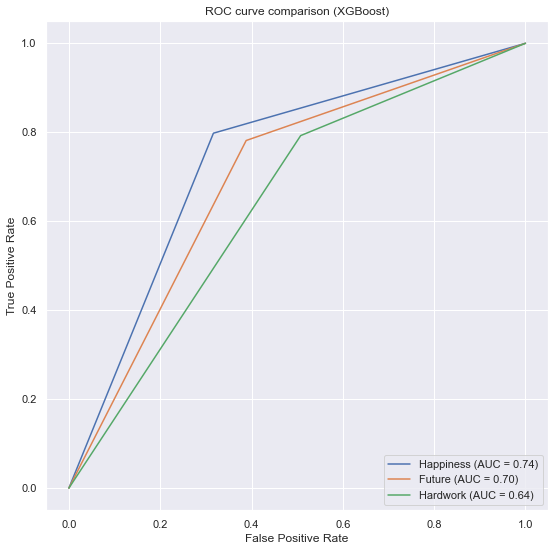

In [12]:
def plot_roc(y_true, y_pred, labels):
    fig, ax = plt.subplots(1, 1, figsize=(9,9))
    for label in labels:
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true[label], y_pred[label])
        auc = sklearn.metrics.auc(fpr, tpr)
        display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=label)
        display.plot(ax=ax)
    
    plt.title("ROC curve comparison (XGBoost)")
    plt.savefig("../../results/XGBoost_ROC.pdf")
    plt.show()
    

plot_roc(y_test, y_preds, y_test.columns)

In [9]:
results = pd.read_csv("../../results/model_scores.csv", index_col=0)

if results.Model.isin(["XGBoost"]).any(axis=None)==False:
    for i in y_train.columns:
        
        s = pd.DataFrame(scores[i]).reset_index()
        s["Target"] = i
        s["Model"] = "XGBoost"
        s = s.loc[s.index==1]
        results = pd.concat([results, s], axis=0)
        results = results.drop(["Best Hyperparameters", "index"], axis=1)
    
results

,Best training score,Accuracy,F1 score,AUC,Target,Model
1,0.755712,0.747941,0.775660,0.742803,Happiness,Logistic Regression
1,0.717608,0.714992,0.752504,0.706899,Future,Logistic Regression
1,0.667356,0.669687,0.731773,0.649861,Hardwork,Logistic Regression
1,0.707724,0.668040,0.701260,0.663379,Happiness,KNN
1,0.670031,0.645799,0.700974,0.633656,Future,KNN
1,0.620391,0.620264,0.690396,0.600125,Hardwork,KNN
1,0.745005,0.734761,0.764964,0.729112,Happiness,Random Forest
1,0.707724,0.694399,0.734811,0.686013,Future,Random Forest
1,0.662204,0.662273,0.729551,0.639761,Hardwork,Random Forest
1,0.746859,0.745470,0.772627,0.740663,Happiness,XGBoost


In [10]:
results.to_csv("../../results/model_scores.csv")